In [1]:
%matplotlib inline
import os
import re
import matplotlib.pyplot as plt

Enter the variable name (e.g., CORE_UTILIZATION): SYNTH_MINIMUM_KEEP_SIZE


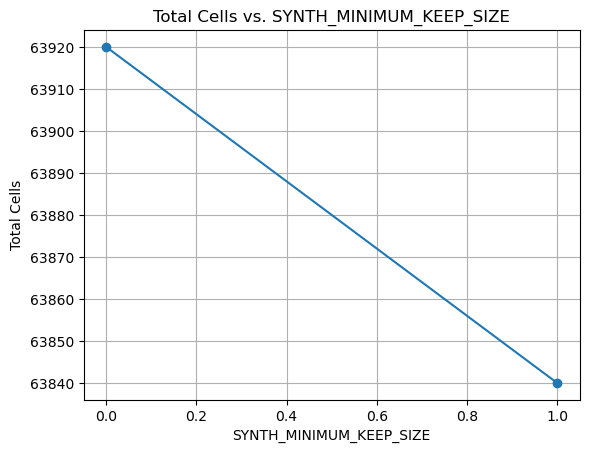

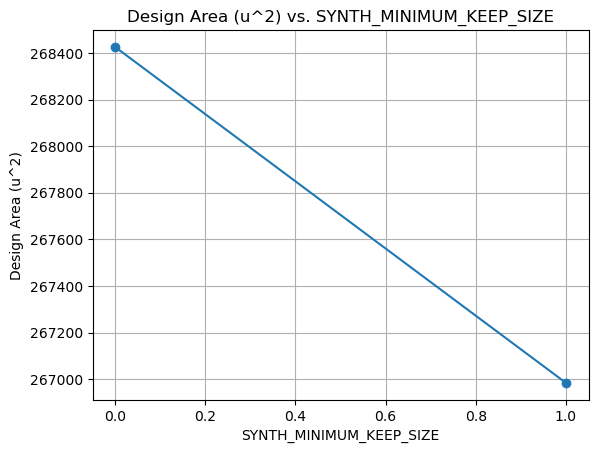

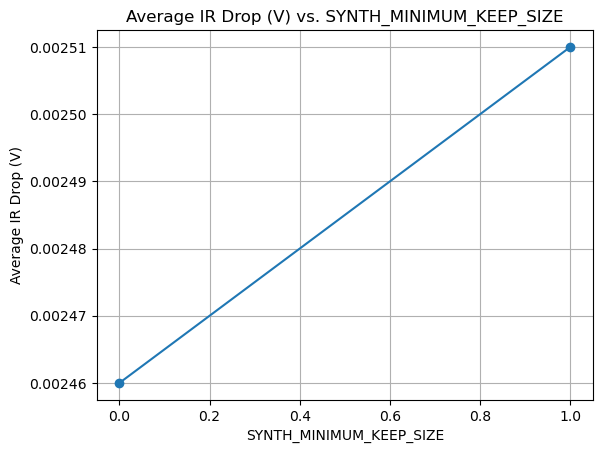

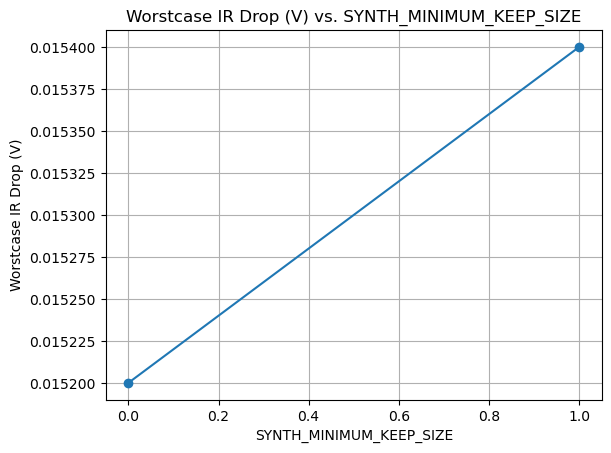

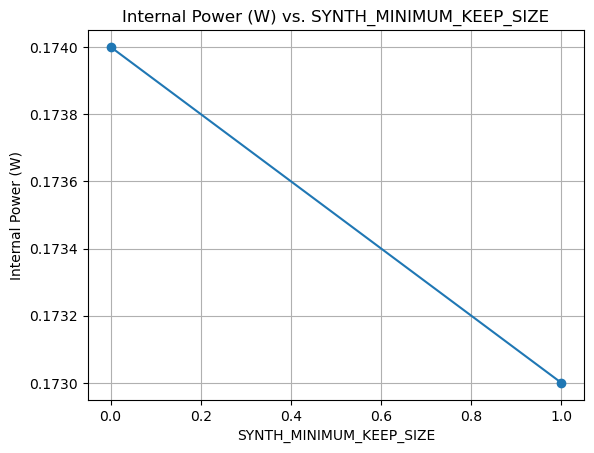

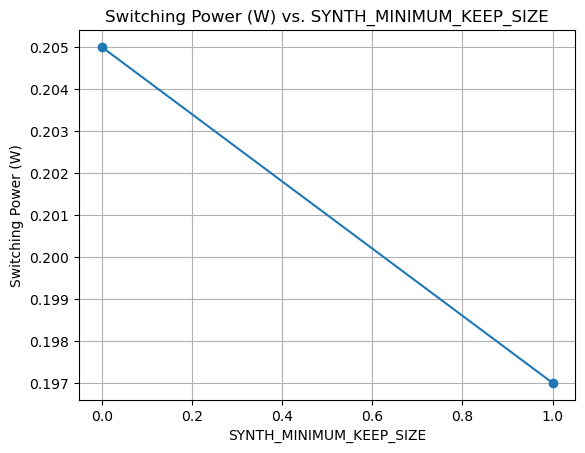

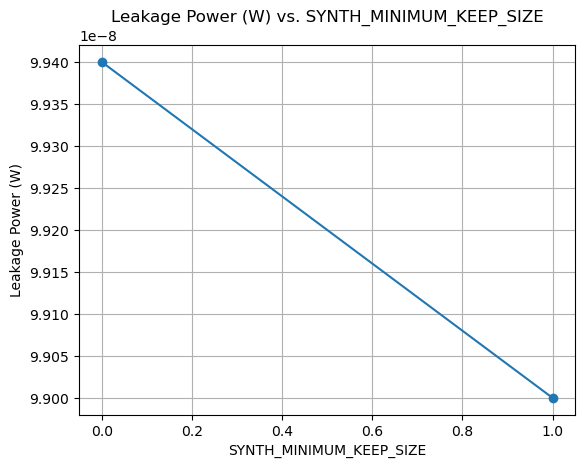

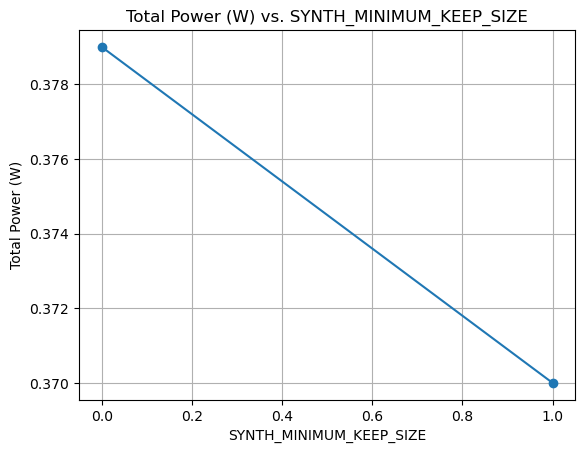

In [12]:
def main():
    # Input the variable name
    design_name = "sha256_unrolled_pipelined" #input("Enter the design name : ")
    variable_name = input("Enter the variable name (e.g., CORE_UTILIZATION): ")

    # Top-level directory
    top_dir = f"logs_{design_name}"

    # Find subfolders matching the variable name
    subfolders = [f for f in os.listdir(top_dir) if f.startswith(variable_name + " ")]

    # Extract variable values and sort them
    values = []
    for folder in subfolders:
        match = re.search(r'\s+([0-9]+(?:\.[0-9]+)?)$', folder)
        if match:
            value = float(match.group(1))
            values.append((value, os.path.join(top_dir, folder)))
    values.sort()  # Sort by variable value
    
    # Initialize lists for parameters
    total_cells_list = []
    design_area_list = []
    avg_ir_drop_list = []
    worst_ir_drop_list = []
    internal_power_list = []
    switching_power_list = []
    leakage_power_list = []
    total_power_list = []
    variable_values = []
    
    # Process each subfolder
    for value, folder in values:
        # --- Process 6_report.log ---
        log_file = os.path.join(folder, "logs", "6_report.log")
        if os.path.exists(log_file):
            with open(log_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    # Extract Total Number of Cells
                    if "Total" in line:
                        match = re.search(r'Total\s+(\d+)', line)
                        if match:
                            total_cells_list.append(int(match.group(1)))
                    # Extract Design Area
                    if "Design area" in line:
                        match = re.search(r'Design area (\d+)', line)
                        if match:
                            design_area_list.append(int(match.group(1)))
                    # Extract Average IR Drop
                    if "Average IR drop" in line:
                        match = re.search(r'Average IR drop\s+:\s+([\d.e+-]+)', line)
                        if match:
                            #print(match.group(1))
                            avg_ir_drop_list.append(float(match.group(1)))
                    # Extract Worstcase IR Drop
                    if "Worstcase IR drop" in line:
                        match = re.search(r'Worstcase IR drop:\s+([\d.e+-]+)', line)
                        if match:
                            worst_ir_drop_list.append(float(match.group(1)))
        else:
            print(f"File not found: {log_file}")
            continue
        
        
        # --- Process 6_finish.rpt ---
        rpt_file = os.path.join(folder, "reports", "6_finish.rpt")
        if os.path.exists(rpt_file):
            with open(rpt_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip().startswith("Total"):
                        parts = line.split()
                        if len(parts) >= 5:  # Ensure line has enough columns
                            internal_power_list.append(float(parts[1]))
                            switching_power_list.append(float(parts[2]))
                            leakage_power_list.append(float(parts[3]))
                            total_power_list.append(float(parts[4]))
                        break  # Only process the first "Total" line
        else:
            print(f"File not found: {rpt_file}")
            continue
        # Store the variable value for this subfolder
        variable_values.append(value)
    avg_ir_drop_list = avg_ir_drop_list[::2]
    worst_ir_drop_list = worst_ir_drop_list[::2]
    
    # Define parameters for plotting
    parameters = [
        ("Total Cells", total_cells_list),
        ("Design Area (u^2)", design_area_list),
        ("Average IR Drop (V)", avg_ir_drop_list),
        ("Worstcase IR Drop (V)", worst_ir_drop_list),
        ("Internal Power (W)", internal_power_list),
        ("Switching Power (W)", switching_power_list),
        ("Leakage Power (W)", leakage_power_list),
        ("Total Power (W)", total_power_list),
    ]

    # Create a folder to save plots inside a folder named after the variable
    plots_dir = os.path.join("plots", variable_name)
    os.makedirs(plots_dir, exist_ok=True)

    # Generate and save plots
    for param_name, param_values in parameters:
        plt.figure()
        plt.plot(variable_values, param_values, marker='o')
        plt.xlabel(variable_name)
        plt.ylabel(param_name)
        plt.title(f"{param_name} vs. {variable_name}")
        plt.grid(True)

        # Save the plot
        safe_param_name = param_name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("^", "")
        filename = os.path.join(plots_dir, f"{safe_param_name}_vs_{variable_name}.png")
        plt.savefig(filename)

        # Also show it in notebook
        plt.show()
    
main()